In [1]:
!wget -O NCT-CRC-HE-100K.zip https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
!unzip -qq NCT-CRC-HE-100K.zip -d train
!pip install torchinfo

--2025-02-09 07:35:09--  https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.43.25, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1214456/files/NCT-CRC-HE-100K.zip [following]
--2025-02-09 07:35:09--  https://zenodo.org/records/1214456/files/NCT-CRC-HE-100K.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 11690284003 (11G) [application/octet-stream]
Saving to: ‘NCT-CRC-HE-100K.zip’

NCT-CRC-HE-100K.zip 100%[===================>]  10.89G  12.0MB/s    in 13m 24s 

2025-02-09 07:48:33 (13.9 MB/s) - ‘NCT-CRC-HE-100K.zip’ saved [11690284003/11690284003]



In [2]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np
from tqdm import tqdm

import itertools
from torchinfo import summary
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
from PIL import Image

from matplotlib import pyplot as plt

import random
import torchvision.transforms.functional as TF

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

import torch.nn.functional as F

In [3]:
class ConvNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super(ConvNorm, self).__init__()
        self.linear = nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size,
            stride=stride, padding=padding, bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.linear(x)
        x = self.bn(x)
        return x

In [4]:
class Stem16(nn.Module):
    def __init__(self):
        super(Stem16, self).__init__()
        self.conv1 = ConvNorm(3, 32)
        self.act1 = nn.Hardswish()
        self.conv2 = ConvNorm(32, 64)
        self.act2 = nn.Hardswish()
        self.conv3 = ConvNorm(64, 128)
        self.act3 = nn.Hardswish()
        self.conv4 = ConvNorm(128, 256)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.act2(self.conv2(x))
        x = self.act3(self.conv3(x))
        x = self.conv4(x)
        return x

In [5]:
class LinearNorm(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearNorm, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=False)
        self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):

        if x.dim() == 3:
            B, N, C = x.shape
            x = x.reshape(B * N, C)
            x = self.bn(self.linear(x))
            x = x.reshape(B, N, -1)
        else:
            x = self.bn(self.linear(x))
        return x

In [6]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads, attn_ratio=2):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        inner_dim = head_dim * num_heads * 3
        self.qkv = LinearNorm(dim, inner_dim)

        self.proj = nn.Sequential(
            nn.Hardswish(),
            LinearNorm(dim, dim)
        )

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x)
        qkv = qkv.view(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(x)

In [7]:
class LevitMlp(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(LevitMlp, self).__init__()
        self.ln1 = LinearNorm(in_features, hidden_features)
        self.act = nn.Hardswish()
        self.drop = nn.Dropout(p=0.5, inplace=False)#dropout 적용
        self.ln2 = LinearNorm(hidden_features, out_features)

    def forward(self, x):
        x = self.ln1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.ln2(x)
        return x

In [8]:
class LevitBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=2):
        super(LevitBlock, self).__init__()
        self.attn = Attention(dim, num_heads)
        self.drop_path1 = nn.Identity()
        self.mlp = LevitMlp(dim, dim * mlp_ratio, dim)
        self.drop_path2 = nn.Identity()

    def forward(self, x):
        x = x + self.drop_path1(self.attn(x))
        x = x + self.drop_path2(self.mlp(x))
        return x

In [9]:
class CNNDownsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CNNDownsample, self).__init__()
        self.out_channels = out_channels
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.act = nn.Hardswish()

    def forward(self, x):
        # print(x.shape)
        B, N, C = x.shape # (B, N, C)  N=H*W (16 * 16 = 196)
        H = int(np.sqrt(N))
        x = x.view(B, H, H, C).permute(0, 3, 1, 2)
        x = self.conv(x)
        x = self.act(x)
        x = x.permute(0, 2, 3, 1).view(B, -1, self.out_channels)
        return x

In [10]:
class ConvLevitStage(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks, kernel_size, stride, padding):
        super(ConvLevitStage, self).__init__()
        self.layers = nn.Sequential(
            *[nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size, stride, padding)
              for i in range(num_blocks)],
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.layers(x)

In [11]:
class NormLinear(nn.Module):
    def __init__(self, in_features, out_features, dropout_prob=0.5):#drop_out_0.5 적용
        super(NormLinear, self).__init__()
        self.bn = nn.BatchNorm1d(in_features)
        self.drop = nn.Dropout(p=dropout_prob, inplace=False)
        self.linear = nn.Linear(in_features, out_features, bias=True)

    def forward(self, x):
        x = self.bn(x)
        x = self.drop(x)
        x = self.linear(x)
        return x

In [12]:
class SimpleNormLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(SimpleNormLinear, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=True)  # Norm 제거

    def forward(self, x):
        return self.linear(x)

In [13]:
class LearnableMask(nn.Module):
    def __init__(self, num_layers):
        super(LearnableMask, self).__init__()
        self.mask_logits = nn.Parameter(torch.randn(num_layers))  # Learnable mask weights

    def forward(self):
        # Differentiable Gumbel-Softmax Sampling
        tau = 1.0  # Temperature parameter
        gumbel_noise = -torch.log(-torch.log(torch.rand_like(self.mask_logits)))  # Gumbel noise
        mask_probs = F.softmax((self.mask_logits + gumbel_noise) / tau, dim=0)
        return mask_probs

In [14]:
class PrunedLevitStage(nn.Module):
    def __init__(self, dim, out_dim, num_heads, num_blocks, downsample=True):
        super(PrunedLevitStage, self).__init__()
        self.downsample = CNNDownsample(dim, out_dim) if downsample else nn.Identity()
        self.blocks = nn.ModuleList([LevitBlock(out_dim, num_heads) for _ in range(num_blocks)])
        self.learnable_mask = LearnableMask(num_blocks)

    def forward(self, x):
        x = self.downsample(x)

        if self.training:  # Gumbel-Softmax 사용
            mask_probs = self.learnable_mask()
        else:  # Deterministic Mask
            mask_probs = F.softmax(self.learnable_mask.mask_logits, dim=0).detach()

        for i, block in enumerate(self.blocks):
            if mask_probs[i] > 0.5:
                x = block(x)

        return x

In [17]:
class PrunedLevitDistilled(nn.Module):
    def __init__(self, num_classes=9):
        super(PrunedLevitDistilled, self).__init__()

        self.stem = Stem16()
        self.stage1 = PrunedLevitStage(dim=256, out_dim=256, num_heads=4, num_blocks=4, downsample=False)
        self.stage2 = PrunedLevitStage(dim=256, out_dim=384, num_heads=6, num_blocks=4, downsample=True)

        self.conv1x1 = nn.Sequential(
            nn.Conv2d(384, 512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.head = SimpleNormLinear(in_features=512, out_features=num_classes)
        self.head_dist = SimpleNormLinear(in_features=512, out_features=num_classes)

    def forward(self, x):
        x = self.stem(x)

        B, C, H, W = x.shape
        x = x.view(B, C, -1).transpose(1, 2)
        x = self.stage1(x)
        x = self.stage2(x)

        H = W = int(x.shape[1]**0.5)
        x = x.transpose(1, 2).view(B, 384, H, W)

        x = self.conv1x1(x)

        x = torch.mean(x, dim=(2, 3))
        out = self.head(x)
        out_dist = self.head_dist(x)
        return out

In [18]:
model = PrunedLevitDistilled(num_classes=9)
print(model)

PrunedLevitDistilled(
  (stem): Stem16(
    (conv1): ConvNorm(
      (linear): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act1): Hardswish()
    (conv2): ConvNorm(
      (linear): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act2): Hardswish()
    (conv3): ConvNorm(
      (linear): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act3): Hardswish()
    (conv4): ConvNorm(
      (linear): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stage1): PrunedLe

In [19]:
print(summary(model, input_size=(32, 3, 224, 224), verbose=2))

Layer (type:depth-idx)                                  Output Shape              Param #
PrunedLevitDistilled                                    [32, 9]                   --
├─Stem16: 1-1                                           [32, 256, 14, 14]         --
│    └─conv1.linear.weight                                                        ├─864
│    └─conv1.bn.weight                                                            ├─32
│    └─conv1.bn.bias                                                              ├─32
│    └─conv2.linear.weight                                                        ├─18,432
│    └─conv2.bn.weight                                                            ├─64
│    └─conv2.bn.bias                                                              ├─64
│    └─conv3.linear.weight                                                        ├─73,728
│    └─conv3.bn.weight                                                            ├─128
│    └─conv3.bn.bias              

In [20]:
import torch.nn.init as init

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # CUDA 연산 시 동일한 결과 보장
    torch.cuda.manual_seed_all(seed)  # 멀티-GPU 환경에서 동일한 결과 보장
    torch.backends.cudnn.deterministic = True  # CuDNN 연산을 deterministic하게 설정
    torch.backends.cudnn.benchmark = False  # 연산 속도를 희생하고 일관된 연산을 수행

def initialize_weights(m):
    if isinstance(m, nn.Conv2d):  # Conv 레이어 초기화
        init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):  # Linear 레이어 초기화
        init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):  # BatchNorm 초기화
        init.constant_(m.weight, 1)
        init.constant_(m.bias, 0)

set_seed(42)  # 랜덤 시드 고정
model.apply(initialize_weights)

PrunedLevitDistilled(
  (stem): Stem16(
    (conv1): ConvNorm(
      (linear): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act1): Hardswish()
    (conv2): ConvNorm(
      (linear): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act2): Hardswish()
    (conv3): ConvNorm(
      (linear): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act3): Hardswish()
    (conv4): ConvNorm(
      (linear): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stage1): PrunedLe

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

batch_size = 32
learning_rate = 5e-4
decay_rate = 1e-6
num_epochs = 30

In [22]:
train_dir = 'train/NCT-CRC-HE-100K'

In [23]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [24]:
dataset = datasets.ImageFolder(root=train_dir, transform=transform)

In [25]:
import json

with open("./default_index_dict.json", "r") as f:
    index_dict = json.load(f)
load_train_idx = index_dict["train_idx"]
load_val_idx = index_dict["val_idx"]
load_test_idx = index_dict["test_idx"]

In [26]:
train_data = Subset(dataset, load_train_idx)
val_data = Subset(dataset, load_val_idx)
test_data = Subset(dataset, load_test_idx)

In [27]:
g = torch.Generator()
g.manual_seed(42)  # 전체 난수 시퀀스를 고정

train_loader = DataLoader(
    train_data, batch_size=batch_size, shuffle=True, num_workers=4,
    worker_init_fn=lambda worker_id: np.random.seed(42 + worker_id),
    generator=g  # 🔹 DataLoader의 난수 시퀀스를 고정
)

val_loader = DataLoader(
    val_data, batch_size=batch_size, shuffle=False, num_workers=4,
    worker_init_fn=lambda worker_id: np.random.seed(42 + worker_id),
    generator=g
)

test_loader = DataLoader(
    test_data, batch_size=batch_size, shuffle=False, num_workers=4,
    worker_init_fn=lambda worker_id: np.random.seed(42 + worker_id),
    generator=g
)
print(f"Train set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Train set size: 70000
Validation set size: 15000
Test set size: 15000


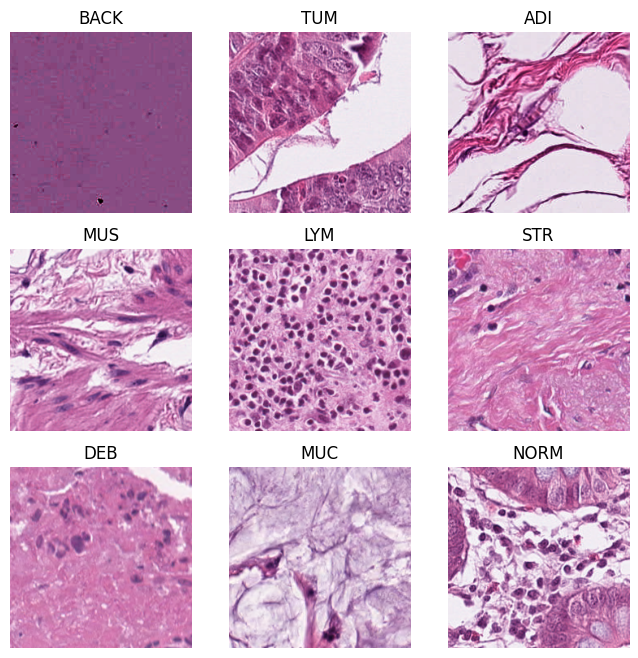

In [28]:
# Show one example per class from the training dataset
import matplotlib.pyplot as plt

# Prepare a dictionary to store one example per class
class_examples = {}
for images, labels in train_loader:
    for img, label in zip(images, labels):
        label = label.item()
        if label not in class_examples:
            class_examples[label] = img
        # Stop if we already have one example for each class
        if len(class_examples) == len(dataset.classes):
            break
    if len(class_examples) == len(dataset.classes):
        break

# Display the images and their labels
figure = plt.figure(figsize=(8, 8))
cols = 3  # You can adjust the number of columns as needed
rows = (len(dataset.classes) + cols - 1) // cols  # Calculate required rows
for i, (label, img) in enumerate(class_examples.items(), start=1):
    figure.add_subplot(rows, cols, i)
    plt.title(dataset.classes[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0).numpy())  # Convert tensor to numpy for display
plt.show()

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [30]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [31]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy:.2f}%")
    train_losses.append(epoch_loss)
    train_accuracies.append(accuracy)

In [32]:
def evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Save all labels and predictions for balanced accuracy
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    balanced_acc = balanced_accuracy_score(all_labels, all_predictions)

    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    val_losses.append(epoch_loss)
    val_accuracies.append(accuracy)

In [33]:
def measure_inference_time(model, data_loader, device):
    model.eval()
    times = []

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            start_time = torch.cuda.Event(enable_timing=True)
            end_time = torch.cuda.Event(enable_timing=True)

            start_time.record()
            _ = model(inputs)  # inference 수행
            end_time.record()

            # 시간 측정
            torch.cuda.synchronize()  # CUDA에서 모든 커널이 완료될 때까지 대기
            elapsed_time = start_time.elapsed_time(end_time)  # 밀리초 단위로 반환
            times.append(elapsed_time)

    # 통계량 계산
    times_np = np.array(times)
    total_inferences = len(times_np)
    avg_time = np.mean(times_np)
    std_dev = np.std(times_np)
    max_time = np.max(times_np)
    min_time = np.min(times_np)

    # 결과 출력
    print(f"Inference Time Measurement Results:")
    print(f"Total Inferences: {total_inferences}")
    print(f"Average Time: {avg_time:.2f} ms")
    print(f"Standard Deviation: {std_dev:.2f} ms")
    print(f"Maximum Time: {max_time:.2f} ms")
    print(f"Minimum Time: {min_time:.2f} ms")

    return times

In [34]:
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train(model, train_loader, criterion, optimizer, device)
    evaluate(model, val_loader, criterion, device, phase="Validation")


Epoch 1/30


Training: 100%|██████████| 2188/2188 [00:53<00:00, 41.06it/s]


Train Loss: 0.5149, Train Accuracy: 81.70%


Validation: 100%|██████████| 469/469 [00:09<00:00, 51.72it/s]


Validation Loss: 1.0478, Validation Accuracy: 79.61%
Balanced Accuracy: 0.7810

Epoch 2/30


Training: 100%|██████████| 2188/2188 [00:54<00:00, 40.52it/s]


Train Loss: 0.2439, Train Accuracy: 91.70%


Validation: 100%|██████████| 469/469 [00:09<00:00, 50.27it/s]


Validation Loss: 0.8165, Validation Accuracy: 73.37%
Balanced Accuracy: 0.7280

Epoch 3/30


Training: 100%|██████████| 2188/2188 [00:54<00:00, 40.29it/s]


Train Loss: 0.1737, Train Accuracy: 94.08%


Validation: 100%|██████████| 469/469 [00:09<00:00, 50.92it/s]


Validation Loss: 0.6137, Validation Accuracy: 84.16%
Balanced Accuracy: 0.8336

Epoch 4/30


Training: 100%|██████████| 2188/2188 [00:53<00:00, 40.63it/s]


Train Loss: 0.1377, Train Accuracy: 95.35%


Validation: 100%|██████████| 469/469 [00:09<00:00, 51.32it/s]


Validation Loss: 0.5704, Validation Accuracy: 80.84%
Balanced Accuracy: 0.8014

Epoch 5/30


Training: 100%|██████████| 2188/2188 [00:51<00:00, 42.39it/s]


Train Loss: 0.1190, Train Accuracy: 96.02%


Validation: 100%|██████████| 469/469 [00:09<00:00, 50.82it/s]


Validation Loss: 1.0579, Validation Accuracy: 80.49%
Balanced Accuracy: 0.7941

Epoch 6/30


Training: 100%|██████████| 2188/2188 [00:54<00:00, 39.99it/s]


Train Loss: 0.1001, Train Accuracy: 96.67%


Validation: 100%|██████████| 469/469 [00:09<00:00, 50.90it/s]


Validation Loss: 0.6969, Validation Accuracy: 83.37%
Balanced Accuracy: 0.8172

Epoch 7/30


Training: 100%|██████████| 2188/2188 [00:53<00:00, 40.61it/s]


Train Loss: 0.0916, Train Accuracy: 96.95%


Validation: 100%|██████████| 469/469 [00:09<00:00, 51.38it/s]


Validation Loss: 8.8804, Validation Accuracy: 25.72%
Balanced Accuracy: 0.2616

Epoch 8/30


Training: 100%|██████████| 2188/2188 [00:54<00:00, 40.10it/s]


Train Loss: 0.0754, Train Accuracy: 97.47%


Validation: 100%|██████████| 469/469 [00:09<00:00, 51.31it/s]


Validation Loss: 0.2738, Validation Accuracy: 90.43%
Balanced Accuracy: 0.8992

Epoch 9/30


Training: 100%|██████████| 2188/2188 [00:54<00:00, 40.17it/s]


Train Loss: 0.0700, Train Accuracy: 97.69%


Validation: 100%|██████████| 469/469 [00:09<00:00, 48.79it/s]


Validation Loss: 2.0902, Validation Accuracy: 64.35%
Balanced Accuracy: 0.6332

Epoch 10/30


Training: 100%|██████████| 2188/2188 [00:55<00:00, 39.51it/s]


Train Loss: 0.0652, Train Accuracy: 97.77%


Validation: 100%|██████████| 469/469 [00:09<00:00, 50.89it/s]


Validation Loss: 0.7354, Validation Accuracy: 82.53%
Balanced Accuracy: 0.8148

Epoch 11/30


Training: 100%|██████████| 2188/2188 [00:55<00:00, 39.69it/s]


Train Loss: 0.0563, Train Accuracy: 98.07%


Validation: 100%|██████████| 469/469 [00:09<00:00, 51.92it/s]


Validation Loss: 0.6609, Validation Accuracy: 80.61%
Balanced Accuracy: 0.8172

Epoch 12/30


Training: 100%|██████████| 2188/2188 [00:54<00:00, 40.10it/s]


Train Loss: 0.0531, Train Accuracy: 98.20%


Validation: 100%|██████████| 469/469 [00:08<00:00, 54.20it/s]


Validation Loss: 0.4521, Validation Accuracy: 86.73%
Balanced Accuracy: 0.8687

Epoch 13/30


Training: 100%|██████████| 2188/2188 [00:54<00:00, 40.44it/s]


Train Loss: 0.0465, Train Accuracy: 98.45%


Validation: 100%|██████████| 469/469 [00:08<00:00, 52.39it/s]


Validation Loss: 0.1008, Validation Accuracy: 96.73%
Balanced Accuracy: 0.9662

Epoch 14/30


Training: 100%|██████████| 2188/2188 [00:54<00:00, 40.35it/s]


Train Loss: 0.0459, Train Accuracy: 98.47%


Validation: 100%|██████████| 469/469 [00:09<00:00, 51.92it/s]


Validation Loss: 0.4127, Validation Accuracy: 90.07%
Balanced Accuracy: 0.8984

Epoch 15/30


Training: 100%|██████████| 2188/2188 [00:54<00:00, 40.27it/s]


Train Loss: 0.0423, Train Accuracy: 98.62%


Validation: 100%|██████████| 469/469 [00:08<00:00, 52.21it/s]


Validation Loss: 0.8258, Validation Accuracy: 85.78%
Balanced Accuracy: 0.8527

Epoch 16/30


Training: 100%|██████████| 2188/2188 [00:54<00:00, 40.32it/s]


Train Loss: 0.0369, Train Accuracy: 98.79%


Validation: 100%|██████████| 469/469 [00:09<00:00, 51.52it/s]


Validation Loss: 0.0497, Validation Accuracy: 98.51%
Balanced Accuracy: 0.9841

Epoch 17/30


Training: 100%|██████████| 2188/2188 [00:54<00:00, 39.97it/s]


Train Loss: 0.0351, Train Accuracy: 98.79%


Validation: 100%|██████████| 469/469 [00:09<00:00, 51.03it/s]


Validation Loss: 0.4277, Validation Accuracy: 90.38%
Balanced Accuracy: 0.8877

Epoch 18/30


Training: 100%|██████████| 2188/2188 [00:54<00:00, 40.05it/s]


Train Loss: 0.0342, Train Accuracy: 98.87%


Validation: 100%|██████████| 469/469 [00:09<00:00, 51.01it/s]


Validation Loss: 0.0843, Validation Accuracy: 97.35%
Balanced Accuracy: 0.9715

Epoch 19/30


Training: 100%|██████████| 2188/2188 [00:54<00:00, 39.87it/s]


Train Loss: 0.0293, Train Accuracy: 98.97%


Validation: 100%|██████████| 469/469 [00:09<00:00, 51.43it/s]


Validation Loss: 0.7313, Validation Accuracy: 85.10%
Balanced Accuracy: 0.8420

Epoch 20/30


Training: 100%|██████████| 2188/2188 [00:54<00:00, 40.15it/s]


Train Loss: 0.0310, Train Accuracy: 98.96%


Validation: 100%|██████████| 469/469 [00:09<00:00, 51.25it/s]


Validation Loss: 0.4109, Validation Accuracy: 89.32%
Balanced Accuracy: 0.8883

Epoch 21/30


Training: 100%|██████████| 2188/2188 [00:54<00:00, 39.90it/s]


Train Loss: 0.0263, Train Accuracy: 99.13%


Validation: 100%|██████████| 469/469 [00:09<00:00, 51.31it/s]


Validation Loss: 0.0370, Validation Accuracy: 98.78%
Balanced Accuracy: 0.9873

Epoch 22/30


Training: 100%|██████████| 2188/2188 [00:54<00:00, 40.02it/s]


Train Loss: 0.0254, Train Accuracy: 99.15%


Validation: 100%|██████████| 469/469 [00:09<00:00, 50.21it/s]


Validation Loss: 3.7120, Validation Accuracy: 54.08%
Balanced Accuracy: 0.5190

Epoch 23/30


Training: 100%|██████████| 2188/2188 [00:54<00:00, 40.07it/s]


Train Loss: 0.0230, Train Accuracy: 99.21%


Validation: 100%|██████████| 469/469 [00:09<00:00, 50.56it/s]


Validation Loss: 0.2883, Validation Accuracy: 92.49%
Balanced Accuracy: 0.9181

Epoch 24/30


Training: 100%|██████████| 2188/2188 [00:54<00:00, 40.31it/s]


Train Loss: 0.0228, Train Accuracy: 99.20%


Validation: 100%|██████████| 469/469 [00:09<00:00, 50.91it/s]


Validation Loss: 0.0341, Validation Accuracy: 98.87%
Balanced Accuracy: 0.9882

Epoch 25/30


Training: 100%|██████████| 2188/2188 [00:54<00:00, 39.91it/s]


Train Loss: 0.0220, Train Accuracy: 99.23%


Validation: 100%|██████████| 469/469 [00:09<00:00, 51.78it/s]


Validation Loss: 0.0685, Validation Accuracy: 97.96%
Balanced Accuracy: 0.9792

Epoch 26/30


Training: 100%|██████████| 2188/2188 [00:54<00:00, 40.35it/s]


Train Loss: 0.0201, Train Accuracy: 99.33%


Validation: 100%|██████████| 469/469 [00:09<00:00, 52.00it/s]


Validation Loss: 0.2259, Validation Accuracy: 93.83%
Balanced Accuracy: 0.9337

Epoch 27/30


Training: 100%|██████████| 2188/2188 [00:54<00:00, 40.31it/s]


Train Loss: 0.0205, Train Accuracy: 99.30%


Validation: 100%|██████████| 469/469 [00:09<00:00, 51.98it/s]


Validation Loss: 0.1046, Validation Accuracy: 96.97%
Balanced Accuracy: 0.9680

Epoch 28/30


Training: 100%|██████████| 2188/2188 [00:55<00:00, 39.76it/s]


Train Loss: 0.0196, Train Accuracy: 99.33%


Validation: 100%|██████████| 469/469 [00:09<00:00, 51.69it/s]


Validation Loss: 0.2386, Validation Accuracy: 94.27%
Balanced Accuracy: 0.9390

Epoch 29/30


Training: 100%|██████████| 2188/2188 [00:54<00:00, 40.21it/s]


Train Loss: 0.0165, Train Accuracy: 99.45%


Validation: 100%|██████████| 469/469 [00:09<00:00, 51.32it/s]


Validation Loss: 0.0288, Validation Accuracy: 99.21%
Balanced Accuracy: 0.9922

Epoch 30/30


Training: 100%|██████████| 2188/2188 [00:54<00:00, 39.83it/s]


Train Loss: 0.0167, Train Accuracy: 99.47%


Validation: 100%|██████████| 469/469 [00:09<00:00, 50.74it/s]

Validation Loss: 0.0632, Validation Accuracy: 98.09%
Balanced Accuracy: 0.9789


In [35]:
print("\nFinal Test Evaluation")
evaluate(model, test_loader, criterion, device, phase="Test")


Final Test Evaluation


Test: 100%|██████████| 469/469 [00:09<00:00, 51.28it/s]

Test Loss: 0.0678, Test Accuracy: 98.05%
Balanced Accuracy: 0.9786


In [36]:
print(summary(model, input_size=(32, 3, 224, 224), verbose=2))

Layer (type:depth-idx)                                  Output Shape              Param #
PrunedLevitDistilled                                    [32, 9]                   --
├─Stem16: 1-1                                           [32, 256, 14, 14]         --
│    └─conv1.linear.weight                                                        ├─864
│    └─conv1.bn.weight                                                            ├─32
│    └─conv1.bn.bias                                                              ├─32
│    └─conv2.linear.weight                                                        ├─18,432
│    └─conv2.bn.weight                                                            ├─64
│    └─conv2.bn.bias                                                              ├─64
│    └─conv3.linear.weight                                                        ├─73,728
│    └─conv3.bn.weight                                                            ├─128
│    └─conv3.bn.bias              

In [37]:
print("train_loss length : ", len(train_losses))
print("train_acc length : ", len(train_accuracies))
print("val_loss length : ", len(val_losses))
print("val_acc length : ", len(val_accuracies))

print("val_adj : ", len(val_losses[:num_epochs]))
print("val_acc_adj : ", len(val_accuracies[:num_epochs]))

train_loss length :  30
train_acc length :  30
val_loss length :  31
val_acc length :  31
val_adj :  30
val_acc_adj :  30


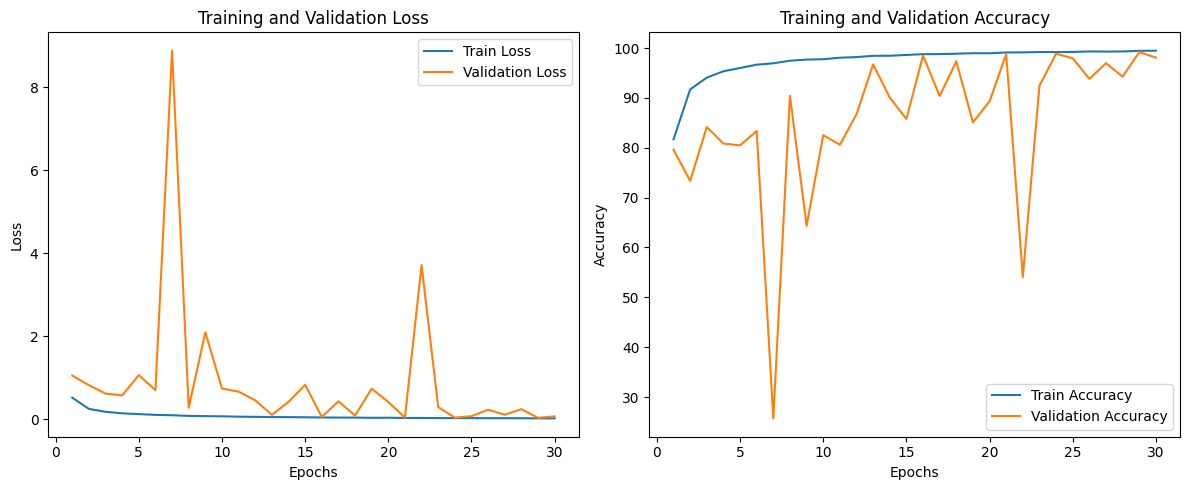

In [38]:
# Plot the metrics
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses[:num_epochs], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies[:num_epochs], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [39]:
times = measure_inference_time(model, test_loader, device)

Inference Time Measurement Results:
Total Inferences: 469
Average Time: 3.61 ms
Standard Deviation: 0.48 ms
Maximum Time: 7.28 ms
Minimum Time: 2.95 ms


In [40]:
from torch import profiler

dummy_input = torch.randn(32, 3, 224, 224).cuda()

# Profiling inference
with profiler.profile(
    activities=[
       profiler.ProfilerActivity.CPU,
        profiler.ProfilerActivity.CUDA,  # Include if using GPU
    ],
    on_trace_ready=profiler.tensorboard_trace_handler("./logs"),  # Optional logging
    record_shapes=True,
    with_stack=True
) as prof:
    with torch.no_grad():
        model(dummy_input)


# Print results
print(prof.key_averages().table(sort_by="cuda_time_total" if torch.cuda.is_available() else "cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::matmul         1.68%     188.809us        13.49%       1.515ms     252.470us       0.000us         0.00%     852.642us     142.107us             6  
                                           aten::conv2d         1.31%     147.685us        35.18%       3.952ms     658.636us       0.000us         0.00%     726.018us     121.003us             6  
         

In [41]:
save_path = "HoViT_TinyFusion_NCT-CRC-HE-100K.pth"
torch.save(model.state_dict(), save_path)
print(f"Model weights saved to {save_path}")

Model weights saved to HoViT_TinyFusion_NCT-CRC-HE-100K.pth


In [42]:
from sklearn.metrics import f1_score, recall_score, precision_score, roc_curve, auc

def score_evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    overall_f1 = f1_score(all_labels, all_preds, average="macro")
    overall_recall = recall_score(all_labels, all_preds, average="macro")
    overall_precision = precision_score(all_labels, all_preds, average="macro")

    f1_per_class = f1_score(all_labels, all_preds, average=None)
    recall_per_class = recall_score(all_labels, all_preds, average=None)
    precision_per_class = precision_score(all_labels, all_preds, average=None)
    class_labels = sorted(set(all_labels))

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    val_losses.append(epoch_loss)
    val_accuracies.append(accuracy)

    print(f"Overall - F1: {overall_f1:.4f}, Recall: {overall_recall:.4f}, Precision: {overall_precision:.4f}")
    print("Per-Class Metrics:")
    for i, label in enumerate(class_labels):
        print(f"Class {label} - F1: {f1_per_class[i]:.4f}, Recall: {recall_per_class[i]:.4f}, Precision: {precision_per_class[i]:.4f}")

    return overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class

In [43]:
from sklearn.preprocessing import label_binarize

def roc_auc(model, data_loader, device, num_classes):

    y = ["F1", "Precision", "Recall"]

    model.eval()
    all_labels = []
    all_scores = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="ROC AUC"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_scores.extend(outputs.cpu().numpy())

    all_labels = label_binarize(all_labels, classes=list(range(num_classes)))
    print(f"Binarized all_labels shape: {all_labels.shape}")
    print(f"All_scores shape: {np.array(all_scores).shape}")

    fpr, tpr, _ = roc_curve(all_labels.ravel(), np.array(all_scores).ravel())
    roc_auc_value = auc(fpr, tpr)

    plt.figure(figsize=(9, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_value:0.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    print(f"Overall ROC AUC: {roc_auc_value:.4f}")

    return fpr, tpr, roc_auc_value

In [44]:
overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class = score_evaluate(model, test_loader, criterion, device, phase="Test")

Test: 100%|██████████| 469/469 [00:09<00:00, 50.39it/s]

Test Loss: 0.0678, Test Accuracy: 98.05%
Overall - F1: 0.9798, Recall: 0.9786, Precision: 0.9813
Per-Class Metrics:
Class 0 - F1: 0.9913, Recall: 0.9859, Precision: 0.9968
Class 1 - F1: 0.9956, Recall: 1.0000, Precision: 0.9912
Class 2 - F1: 0.9759, Recall: 0.9959, Precision: 0.9566
Class 3 - F1: 0.9986, Recall: 0.9977, Precision: 0.9994
Class 4 - F1: 0.9611, Recall: 0.9258, Precision: 0.9992
Class 5 - F1: 0.9808, Recall: 0.9808, Precision: 0.9808
Class 6 - F1: 0.9775, Recall: 0.9741, Precision: 0.9809
Class 7 - F1: 0.9542, Recall: 0.9572, Precision: 0.9512
Class 8 - F1: 0.9829, Recall: 0.9902, Precision: 0.9757


<Figure size 2000x1200 with 0 Axes>

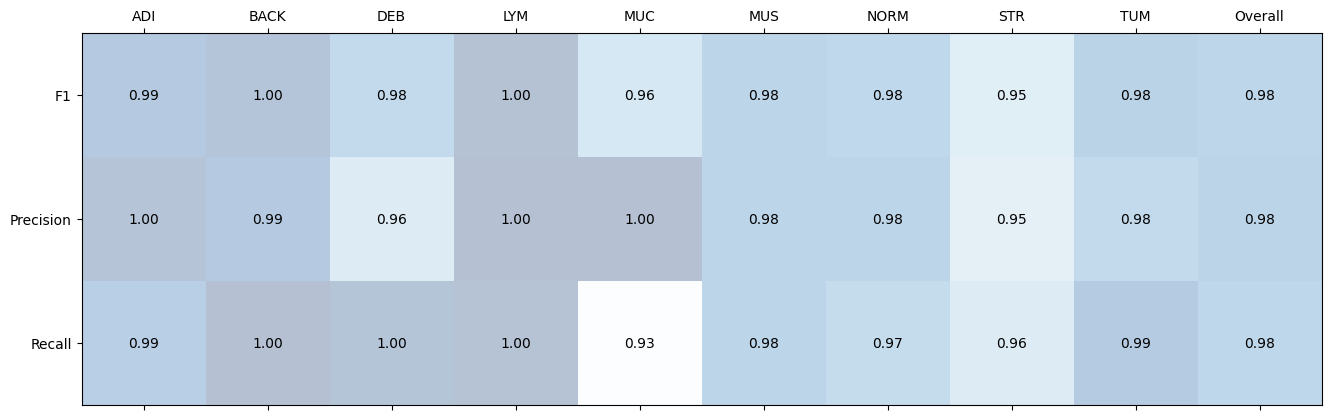

In [45]:
x = ["ADI", "BACK", "DEB", "LYM", "MUC", "MUS", "NORM", 'STR', "TUM"]
y = ["F1", "Precision", "Recall"]

f1_score_list = []
precision_score_list = []
recall_score_list = []

for i, class_name in enumerate(x):
    f1_score_list.append(f1_per_class[i])
    precision_score_list.append(precision_per_class[i])
    recall_score_list.append(recall_per_class[i])

x.append("Overall")
f1_score_list.append(overall_f1)
precision_score_list.append(overall_precision)
recall_score_list.append(overall_recall)

score_list = [f1_score_list, precision_score_list, recall_score_list]
score_list = np.array(score_list)
plt.figure(figsize=(20, 12))
score_cm = plt.matshow(score_list, cmap=plt.cm.Blues, alpha=0.3)
plt.xticks(range(len(x)), x)
plt.yticks(range(len(y)), y)
for i in range(len(y)):
    for j in range(len(x)):
        # 행렬의 각각의 수치를 각 칸의 중앙에 넣어준다
        plt.text(x=j, y=i,
                     s="{:.2f}".format(score_list[i, j]),
                     va='center',
                     ha='center',
                     )

In [46]:
def visualize_pruned_blocks(model):

    for stage_name, stage in model.named_children():
        if isinstance(stage, PrunedLevitStage):
            mask_probs = stage.learnable_mask().detach().cpu().numpy()
            activated_blocks = np.sum(mask_probs > 0.5)
            total_blocks = len(mask_probs)

            print(f"🔥 {stage_name} -activation block number : {activated_blocks}/{total_blocks}")
            print(f"🔹 Block activation prob: {mask_probs}")

            plt.figure(figsize=(8, 1))
            plt.bar(range(total_blocks), mask_probs, color=['red' if p < 0.5 else 'blue' for p in mask_probs])
            plt.axhline(y=0.5, color='gray', linestyle='--')
            plt.xlabel("Block Index")
            plt.ylabel("Activation Probability")
            plt.title(f"{stage_name} Block Activation")

🔥 stage1 -activation block number : 1/4
🔹 Block activation prob: [0.04608604 0.17175546 0.76018804 0.02197048]
🔥 stage2 -activation block number : 1/4
🔹 Block activation prob: [0.13184018 0.17683402 0.01044049 0.6808853 ]


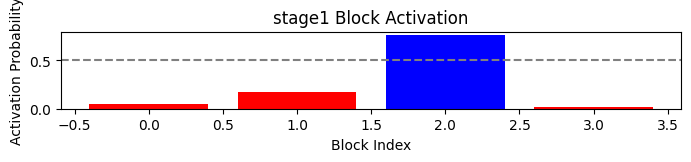

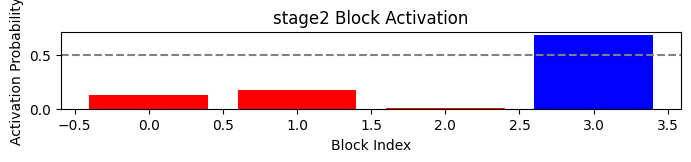

In [47]:
visualize_pruned_blocks(model)